In [41]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pylab as plt
from torch import Tensor

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [42]:
X_train_df = pd.read_csv('data/X_train.csv', index_col=0, sep=',')
X_train_df.columns.name = 'date'

Y_train = pd.read_csv('data/Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

print(f'Shape of training set X is {X_train_df.shape}')
print(f'Shape of training set Y is {Y_train.shape}')

Shape of training set X is (50, 754)
Shape of training set Y is (50, 504)


In [ ]:
class FinancialDataset(Dataset):
    """A PyTorch dataset for financial time series data."""

    def __init__(self, dataframe: pd.DataFrame):
        """
        Initializes the dataset.

        Args:
            dataframe (pd.DataFrame): The input data with shape (50, 504).
        """
        self.y: Tensor = torch.from_numpy(dataframe.values.T)  # Shape: (504, 50)

    def __len__(self) -> int:
        """
        Returns the number of time periods in the dataset.

        Returns:
            int: Number of time periods (504).
        """
        return self.y.shape[0]  # 504 time periods

    def __getitem__(self, idx: int) -> Tensor:
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the time period.

        Returns:
            Tensor: The corresponding time period data with shape (50, 1).
        """
        return self.y[idx, :].unsqueeze(1)  # Shape: (50, 1)

class CNNEncoder(nn.Module):
    """A Convolutional Neural Network (CNN) encoder for feature extraction."""

    def __init__(self, input_dim: int = 1, hidden_dim: int = 250):
        """
        Initializes the CNN encoder.

        Args:
            input_dim (int, optional): Number of input channels. Defaults to 1.
            hidden_dim (int, optional): Number of output channels. Defaults to 250.
        """
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the CNN encoder.

        Args:
            x (Tensor): Input tensor with shape (batch_size, input_dim, 50).

        Returns:
            Tensor: Encoded features with shape (504, 50, 250).
        """
        x = x.view(-1, 1, 50) # Shape: (batch, 1, 50)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x.permute(2, 0, 1)  # Shape: (batch, 50, 250)

# Transformer Encoder
class TransformerEncoderModel(nn.Module):
    """A Transformer-based encoder model for learning financial features.

    This model applies a linear embedding layer followed by a Transformer encoder
    to extract feature representations from stock price data.

    Attributes:
        embedding (nn.Linear): A linear layer that projects input features to `hidden_dim`.
        encoder_layer (TransformerEncoderLayer): A single Transformer encoder layer.
        transformer_encoder (TransformerEncoder): A multi-layer Transformer encoder.
        relu (nn.ReLU): Activation function applied after embedding.
    """

    def __init__(self, input_dim: int = 1, hidden_dim: int = 250, nhead: int = 10, nlayers: int = 4) -> None:
        """Initializes the TransformerEncoderModel.

        Args:
            input_dim (int, optional): The number of input features per stock. Defaults to 1.
            hidden_dim (int, optional): The dimensionality of the feature embeddings. Defaults to 250.
            nhead (int, optional): The number of attention heads in the Transformer. Defaults to 10.
            nlayers (int, optional): The number of Transformer encoder layers. Defaults to 4.
        """
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Transformer encoder model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 50, 1), where 50 represents stocks.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 50, 250), representing the learned features.
        """
        x = x.view(-1, 50, 1)  # Ensure input shape is (batch, 50, 1)
        x = self.embedding(x)  # Shape: (batch, 50, 250)
        x = self.relu(x)
        x = self.transformer_encoder(x)  # Shape: (batch, 50, 250)
        return x

class Decoder(nn.Module):
    """A decoder that reconstructs outputs from encoded features using a learnable parameter beta."""

    def __init__(self, beta: Tensor):
        """
        Initializes the decoder with a learnable beta parameter.

        Args:
            beta (Tensor): Initial weight matrix with shape (250, 1).
        """
        super(Decoder, self).__init__()
        beta_new = beta.clone().float()
        self.beta = nn.Parameter(beta_new, requires_grad=True)

    def forward(self, F: Tensor) -> Tensor:
        """
        Forward pass of the decoder.

        Args:
            F (Tensor): Encoded feature tensor with shape (504, 50, 250).

        Returns:
            Tensor: Predicted output with shape (504, 50).
        """
        y_pred = torch.matmul(F, self.beta).squeeze(-1)  # Shape: (504, 50)
        return y_pred

In [103]:
def correlation_loss(y_pred: Tensor, y_true: Tensor) -> Tensor:
    """Computes the negative correlation loss.

    Args:
        y_pred (Tensor): Predicted output tensor.
        y_true (Tensor): Ground truth tensor.

    Returns:
        Tensor: Negative correlation loss.
    """
    num = torch.sum(y_pred * y_true, dim=0)
    denom = torch.norm(y_pred, dim=0) * torch.norm(y_true, dim=0)
    return -torch.mean(num / denom)

def train_autoencoder(encoder: nn.Module,
                      decoder: nn.Module,
                      optimizer: torch.optim.Optimizer,
                      data_loader: DataLoader,
                      epochs: int = 10) -> list:
    """Trains an autoencoder using the given encoder and decoder.

    Args:
        encoder (nn.Module): The CNN encoder model.
        decoder (nn.Module): The decoder model.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        data_loader (DataLoader): DataLoader for training data.
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        list: List of loss values for each epoch.
    """
    record_loss = []
    for epoch in range(epochs):
        total_loss = 0
        for y_true in data_loader:
            optimizer.zero_grad()
            F = encoder(y_true.float())  # Extract feature tensor (batch, 50, 250)
            y_pred = decoder(F)  # Reconstruct y
            loss = correlation_loss(y_pred, y_true.view(y_pred.shape))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        record_loss.append(total_loss / len(data_loader))
    return record_loss

In [ ]:
dataset = FinancialDataset(Y_train)
data_loader = DataLoader(dataset, batch_size=63, shuffle=True)
decoder = Decoder(beta=torch.randn(250, 1))

# option to use CNN encoder or transformer encoder
# the CNN works better

encoder = CNNEncoder()
# encoder = TransformerEncoderModel(nhead=2, nlayers=1) # 10, 4

In [127]:
n_params_enc = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
n_params_dec = sum(p.numel() for p in decoder.parameters() if p.requires_grad)

In [128]:
print(f'Number of parameters in the encoder is {n_params_enc}')
print(f'Number of parameters in the decoder is {n_params_dec}')

Number of parameters in the encoder is 121210
Number of parameters in the decoder is 250


In [129]:
# test = next(iter(data_loader))
# encoder(test.float())

In [130]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
losses = train_autoencoder(encoder, decoder, optimizer, data_loader, epochs=100)

In [131]:
with torch.no_grad():
    sample_y = dataset[:].float()
    F_learned = encoder(sample_y)
print("Learned Feature Tensor F Shape:", F_learned.shape)

Learned Feature Tensor F Shape: torch.Size([50, 504, 250])


### Find $\beta$

In [132]:
def estimate_A_svd(x_train: np.ndarray, nlatent: int = 10) -> np.ndarray:
    """Estimate the matrix A using Singular Value Decomposition (SVD).

    Args:
        x_train (np.ndarray): Input data matrix of shape (N, D).
        nlatent (int): Number of latent components to retain.

    Returns:
        np.ndarray: Estimated A matrix of shape (D, nlatent).
    """
    U, S, Vt = np.linalg.svd(x_train, full_matrices=False)
    A_svd = Vt.T[:, :nlatent]  # Extract first nlatent singular vectors

    return A_svd

def parameters_transform(
    matrix_A: np.ndarray,
    beta: np.ndarray,
    lag: int = 250,
    nfactors: int = 10,
    save: bool = False,
    fname: str = 'submissionExample'
) -> np.ndarray:
    """
    Transforms the factor loading matrix and beta vector into a single vertically stacked column vector.

    Args:
        matrix_A (np.ndarray): Factor loading matrix of shape (lag, nfactors).
        beta (np.ndarray): Factor beta vector of shape (nfactors, 1) or (nfactors,).
        lag (int, optional): Number of time lags (default: 250).
        nfactors (int, optional): Number of factors (default: 10).
        save (bool, optional): Option to save the dataframe. Defaults to False.
        fname (str, optional): Filename to save the dataframe. Defaults to 'submissionExample'.

    Returns:
        np.ndarray: A vertically stacked column vector of shape (lag * nfactors + nfactors, 1) = (2510, 1).

    Raises:
        ValueError: If matrix_A does not have shape (lag, nfactors).
        ValueError: If beta does not have shape (nfactors, 1) or (nfactors,).
    """
    # Validate input shapes
    if matrix_A.shape != (lag, nfactors):
        raise ValueError(f"matrix_A must have shape ({lag}, {nfactors}), but got {matrix_A.shape}.")

    if beta.shape not in [(nfactors, 1), (nfactors,)]:
        raise ValueError(f"beta must have shape ({nfactors}, 1) or ({nfactors},), but got {beta.shape}.")

    # Ensure beta is a column vector
    beta = beta.reshape(nfactors, 1)

    # Flatten matrix_A row-wise and stack with beta
    output = np.hstack((np.hstack([matrix_A.T, beta])).T )

    # store the output
    if save:
        pd.DataFrame(output).to_csv(f'submissions/{fname}.csv')

    return output

In [133]:
y_true_reshaped = Y_train.values.reshape(-1,)
F_reshaped = F_learned.reshape(-1, 250).numpy()
A_svd = estimate_A_svd(F_reshaped)
features = F_reshaped @ A_svd
cov_beta = np.linalg.inv(features.T @ features)
beta = cov_beta @ features.T @ y_true_reshaped

In [134]:
y_pred_tensor = torch.from_numpy(features @ beta).reshape(50, 504)
y_true_tensor = torch.from_numpy(y_true_reshaped).reshape(50, 504)

In [135]:
correlation_loss(y_pred_tensor, y_true_tensor) * -1

tensor(0.9962, dtype=torch.float64)

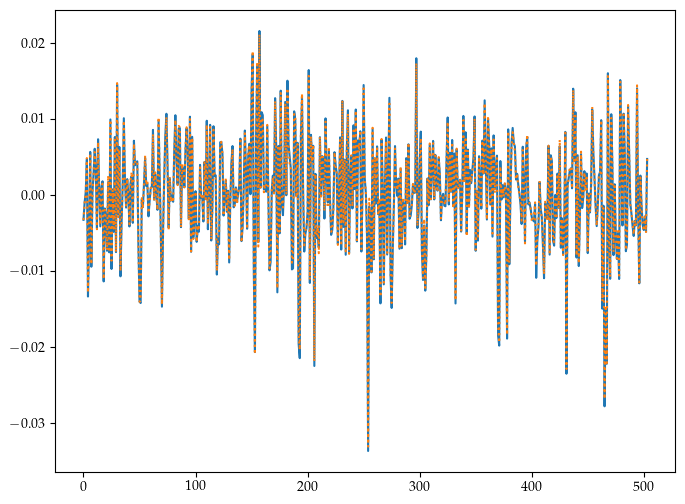

In [136]:
idx = 1
plt.figure(figsize = (8,6))
plt.plot(y_pred_tensor[idx].numpy())
plt.plot(y_true_tensor[idx].numpy(), linestyle = ':')
plt.show()

In [ ]:
# features_reshaped = features.reshape(50, 504, 10)
# outputs = parameters_transform(A_svd, beta, save=True, fname='submission_CNN')